In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import site 
sys.path.insert(0, site.USER_SITE)
sys.path.insert(0, '/UP_home/gregorl/git/R2-scripts')

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

import all_my_code as amc
import xarray as xr
import pandas as pd
import pyseaflux as sf
# import python as r2

amc.data.set_defaults(resolution=1)

from cartopy import crs, feature

[AMC] version: 0.3.4.dev1+g3ae82d7


# Create data from full RECCAP2 datasets

In [4]:
regions = amc.data.reccap2_regions.southern.conform.lon_0E_360E().astype(float).where(lambda x: x>0)

/Users/luke/opt/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
def open_reccap2_data(basedir, dim='model', **kwargs):
    flist = r2.data.get_fnames_recursive_search(basedir=basedir, **kwargs)
    print(f"{len(flist)} files found")
    ds = r2.data.open_reccap2_ocean_data(flist, rename_var_to_model=True)
    if isinstance(ds, list):
        return ds
    da = (
        ds
        .where(lambda x: x < 1e34)
        .sel(time=slice('1985', '2018'))
        .to_array(dim='model'))
    return da

In [65]:
mask = amc.datasets.masks.reccap2_regions(resolution=1).open_ocean.grid.lon_0E_360E() == 5

In [66]:
# models and assimilation
fgco2_models = open_reccap2_data(
    basedir='../reccap2_data/Models/2D_CO2/',
    dim='model',
    include=['_A_', '.nc', 'fgco2_'],
    exclude=['ROMS', 'v20211214', 'GOA', 'ECCO', 'OCIM', '_glob_', '_reg_', 'MPIOM_HAMOCC'])

# data products
fgco2_products = open_reccap2_data(
    basedir='../reccap2_data/Surface_CO2',
    dim='model',
    include=['.nc', 'fgco2_'],
    exclude=['RECCAP-XYT', '_glob_', '_reg_', 'AOML', ])

13 files found
ADDED: fgco2_CCSM-WHOI_A_1_gr_1958-2017_20211125.nc
ADDED: fgco2_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc
ADDED: fgco2_CNRM-ESM2-1_A_1_gr_1980-2018_v20211208.nc
ADDED: fgco2_EC-Earth3_A_1_gr_1980-2018_v20220323.nc
ADDED: fgco2_FESOM_REcoM_HR_A_1_gr_1980-2018_v20211119.nc
ADDED: fgco2_FESOM_REcoM_LR_A_1_gr_1980-2018_v20211119.nc
ADDED: fgco2_MOM6-Princeton_A_1_gr_1980-2018_v20220125.nc
ADDED: fgco2_MPIOM-HAMOCC_A_1_GR15_1980-2019_v20220110.nc
ADDED: fgco2_MRI-ESM2-1_A_1_gr_1980-2018_v20220502.nc
ADDED: fgco2_NorESM-OC1.2_A_1_gr_1980-2018_v20211125.nc
ADDED: fgco2_ORCA025-GEOMAR_A_1_gr_1980-2018_v20210804.nc
ADDED: fgco2_ORCA1-LIM3-PISCES_A_1_gr_1980-2018_v20211215.nc
ADDED: fgco2_PlankTOM12_A_1_gr_1980-2018_v20220404.nc
Trying to merge files
9 files found
ADDED: fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc
ADDED: fgco2_CSIRML6_1985-2018_v20211117.nc
ADDED: fgco2_JMAMLR_1985-2019_v20211208.nc
ADDED: fgco2_JenaMLS_1985-2018_v20211126.nc
ADDED: fgco2_NIES-ML3_1980-2020_v20220

In [67]:
ens = xr.Dataset()
ens['gobm'] = fgco2_models.mean(['model', 'time'])
ens['pco2'] = fgco2_products.mean(['model', 'time'])
ens_avg = ens.to_array(dim='class').mean('class') * -1 * (86400 * 365)
da = amc.viz.maps.fill_lon_gap(ens_avg.sel(lat=slice(-90, -28)))

In [70]:
d = 20
bounds = (
    regions
    .conform()
    .sel(lat=slice(-80,-30))
    .pipe(lambda x: x.fillna(x.fillna(0).where(x.lat > -50)))
    .rolling(lat=2, lon=6, min_periods=1, center=True).mean()
    .roll(lon=d)
    .grid.interp(res=0.25)
    .sel(lat=slice(-80, -30))
    .round()
    .assign_coords(lon=lambda x: (x.lon - d) % 360)
    .sortby('lon')
    .pipe(lambda x: amc.viz.maps.fill_lon_gap(x))
)

In [74]:
cant = (
    xr.open_dataset('./reccap2_fig11.nc')
    .rename(dep='depth')
    .assign_coords(depth=lambda x: -x.depth)
    .sortby('depth')
    .cant_gobm
    .sel(
        depth=slice(-3500, 0),
        lat=slice(-78, -30)))

In [75]:
bounds.to_dataset(name='bounds').to_netcdf('../data/RECCAP2-SO_fig14_boundaries_smooth.nc', encoding={"bounds": dict(zlib=True, complevel=1, dtype='float32')})
da.to_dataset(name='fgco2').to_netcdf('../data/RECCAP2-SO_fig14_fgco2_ens_gobm_co2dp.nc', encoding={"fgco2": dict(zlib=True, complevel=1, dtype='float32')})
cant.to_dataset(name='cant').to_netcdf('../data/RECCAP2-SO_fig14_cant_gobm.nc', encoding={"cant": dict(zlib=True, complevel=1, dtype='float32')})

# Load data

In [10]:
bounds = xr.open_dataarray('../data/RECCAP2-SO_fig14_boundaries_smooth.nc')
fgco2 = xr.open_dataarray('../data/RECCAP2-SO_fig14_fgco2_ens_gobm_co2dp.nc')
cant = xr.open_dataarray('../data/RECCAP2-SO_fig14_cant_gobm.nc')
cnet = xr.open_dataarray('../data/RECCAP2-SO_fig14_cnet_gobm.nc')

# FgCO2

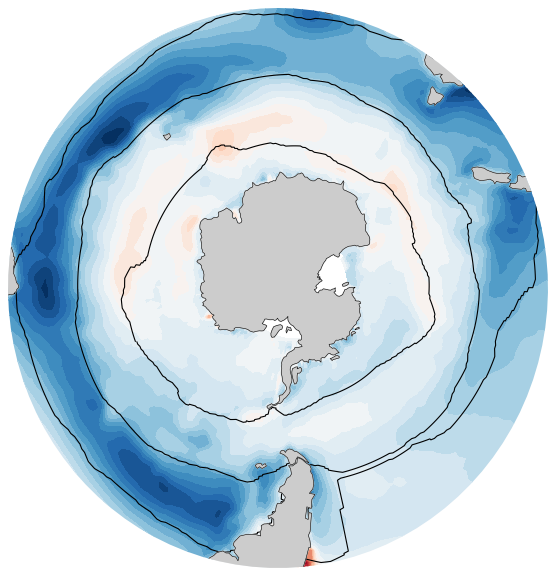

In [6]:
import matplotlib.path as mpath


fig = plt.figure(figsize=[8, 8], dpi=80)
ax = fig.add_subplot(projection=crs.SouthPolarStereo(110), fc='w')
img1 = fgco2.plot.contourf(
    levels=np.arange(-2.6, 2.61, 0.2), 
    add_colorbar=False,
    ax=ax, transform=crs.PlateCarree(), 
)

img2 = bounds.plot.contour(
    colors=['k'], linewidths=1,
    levels=[0, 1, 2], add_colorbar=False, 
    ax=ax, transform=crs.PlateCarree(), 
)

ax.add_feature(feature.COASTLINE.with_scale('110m'), lw=0.5, zorder=11)
ax.add_feature(feature.LAND.with_scale('110m'), color='#cccccc', zorder=10)

ax.spines['geo'].set_linewidth(0.)
ax.spines['geo'].set_zorder(12)


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.set_facecolor('w')
fig.set_facecolor('none')

# plt.savefig('./surface_fgco2.png', dpi=500, transparent=False)

# Cant Section 

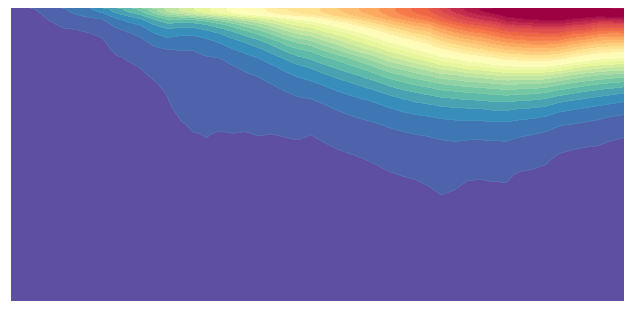

In [8]:
cant = (
    cant
    .sortby('depth')
    .sel(
        depth=slice(-3500, 0),
        lat=slice(-78, -30)))

fig = plt.figure(figsize=[8, 4], dpi=80)
levels = np.arange(1000, 28000, 1000)
img3 = cant.T.plot.contourf(add_colorbar=False, cmap='Spectral_r', levels=levels)
img4 = cant.T.plot.contour (add_colorbar=False, levels=levels, linewidths=0.1, colors=['w'], alpha=0.5)

img3.axes.set_xticks([])
img3.axes.set_yticks([])
img3.axes.set_xlabel('')
img3.axes.set_ylabel('')

[s.set_lw(0) for s in img3.axes.spines.values()]

fig.tight_layout()
# fig.savefig('./section_cant.png', bbox_inches=0, transparent=True, dpi=500)

# Cnet section

In [11]:
vlims = 0.0, 0.9
colors = plt.cm.pink_r(np.linspace(*vlims, 16))
lighter_pink = plt.matplotlib.colors.LinearSegmentedColormap.from_list('pink_lighter', colors)

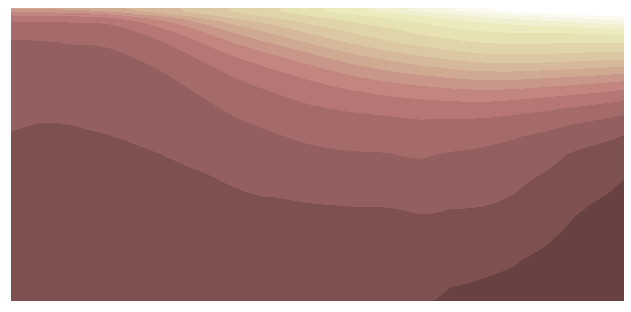

In [12]:
ds = (
    cnet
    .sortby('depth')
    .transpose()
    .sel(
        depth=slice(-3500, 0),
        lat=slice(-78, -30))
    .mean(['model']))


fig = plt.figure(figsize=[8, 4], dpi=80)


img5 = ds.T.plot.contourf(add_colorbar=False, cmap=lighter_pink, levels=colors.shape[0], vmin=2.1, extend='both', robust=True)
# img6 = ds.T.plot.contour (add_colorbar=False, levels=levels, linewidths=0.1, colors=['w'], alpha=0.5)

img5.axes.set_xticks([])
img5.axes.set_yticks([])
img5.axes.set_xlabel('')
img5.axes.set_ylabel('')

[s.set_lw(0) for s in img5.axes.spines.values()]

fig.tight_layout()
# fig.savefig('../section_cnet.png', bbox_inches=0, transparent=True, dpi=500)

# Colorbars

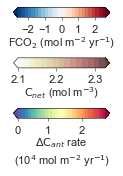

In [13]:
fig, ax = plt.subplots(3, 1, figsize=[1.2, 1.5], dpi=80)
fig.subplots_adjust(hspace=4, left=0, right=1, top=1)

props = dict(orientation='horizontal')

cbar1 = plt.colorbar(img1, cax=ax[0], **props)
cbar2 = plt.colorbar(img3, cax=ax[2], **props, extend='max')
cbar3 = plt.colorbar(img5, cax=ax[1], **props, extend='both')

cbar1.set_ticks(np.arange(-2, 2.1, 1))
cbar2.set_ticks(np.arange(0, 2.1, 1) * 1e4)
cbar3.set_ticks(np.arange(2.1, 2.4, 0.1))

cbar2.set_ticklabels(np.arange(0, 3))

cbar1.set_label('FCO$_2$ (mol m$^{-2}$ yr$^{-1}$)', labelpad=0)
cbar2.set_label('$\Delta \mathrm{C}_{ant}$ rate\n(10$^4$ mol m$^{-2}$ yr$^{-1}$)', labelpad=0)
cbar3.set_label('$\mathrm{C}_{net}$ (mol m$^{-3}$)', labelpad=0)

# fig.savefig('../colorbars3.png', bbox_inches='tight', dpi=300, transparent=True)